In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import sys
sys.path.append("..")
from psflearning.psflearninglib import psflearninglib
from psflearning import io
from psflearning.makeplots import *
import tensorflow as tf
try:
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print('Running on GPU')
except:
    print('Running on CPU')


2024-05-02 17:27:17.855262: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 17:27:18.086918: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-02 17:27:18.593650: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Running on GPU


2024-05-02 17:27:19.427694: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 17:27:19.516936: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-02 17:27:19.517031: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [2]:
import tifffile

In [3]:
import nd2
beads = nd2.imread("../PSF_comparison/100x_PSF_postmag.nd2")

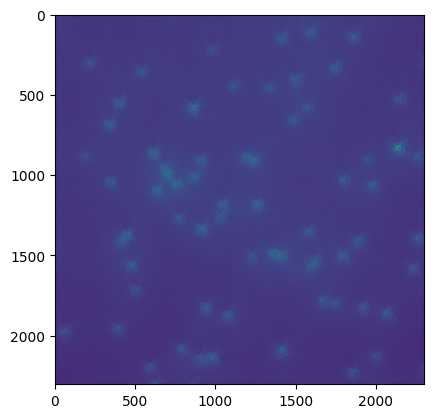

In [4]:
plt.imshow(beads[:,2][0])

In [7]:
green_beads = beads[30:-30,1]
green_beads = green_beads.reshape((1,) + green_beads.shape)
images = green_beads

In [8]:
green_beads.shape

(1, 41, 2304, 2304)

In [245]:
images = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")
images = images.reshape((1,)+images.shape)
#images = np.concatenate([images, images], axis = 2)
images = images.astype(int)


L = psflearninglib()
L.param = io.param.combine('config_base',psftype='zernike',channeltype='1ch',sysfile='M2')
L.param.datapath = '1ch_40nm_bead/'
L.param.savename = L.param.datapath+'psfmodel'
L.param.keyword = 'Pos' # keyword for your data file
L.param.subfolder = 'Pos' # keyword for subfolder name if each data file is saved in a individual folder, set to '' if no subfolder
L.param.gain = 0.22
L.param.ccd_offset = 360
L.param.FOV.z_step = 1  
L.param.pixel_size.z = 0.05 # micron, equal to z_step*stepsize_of_the_data
L.param.pixel_size.y = 0.0655/1.5 
L.param.pixel_size.x = 0.0655/1.5 
L.param.roi_size = [100,100]
L.param.roi.max_bead_number = 30
L.param.roi.bead_radius = 0.1
L.param.batch_size = 30 # lower this number if out of memory
L.param.option.imaging.emission_wavelength = 0.515 # micron
L.param.option.imaging.NA = 1.49
L.param.option.imaging.RI.imm = 1.518

In [246]:
green_beads = beads[30:-30,1]
green_beads = green_beads.reshape((1,) + green_beads.shape)
images = green_beads

In [247]:
images.shape

(1, 41, 2304, 2304)

In [248]:
L.getpsfclass()
dataobj = L.prep_data(images)
for k in range(0,1): # increase iteration number if necessary
    psfobj,fitter = L.learn_psf(dataobj,time=0)
resfile = L.save_result(psfobj,dataobj,fitter)

rois shape channel : (30, 39, 25, 25)


3/6: learning: 213/250 [00:14s] 14.26it/s, current loss: 4.07434, total time: 14.94s
4/6: calculating spline coefficients: 1/1 [00:01s]  1.04s/it total time: 15.98s
4/6: calculating spline coefficients: 1/1 [00:01s]  1.04s/it total time: 15.98s

5/6: localization: 4/4 [00:00s] 24.24it/s total time: 16.15s


outlier id: [ 2  3  6 10 11 15 16 17 18 24 25 28]
rois shape channel : (18, 39, 25, 25)


3/6: learning: 216/250 [00:08s] 24.78it/s, current loss: 3.60258, total time: 24.86s 
4/6: calculating spline coefficients: 1/1 [00:01s]  1.04s/it total time: 25.90s
4/6: calculating spline coefficients: 1/1 [00:01s]  1.04s/it total time: 25.90s

5/6: localization: 4/4 [00:00s] 24.54it/s total time: 26.06s
6/6: saving results: [00:02s] total time: 28.26s


In [249]:
f,p = io.h5.load(resfile) # load result file

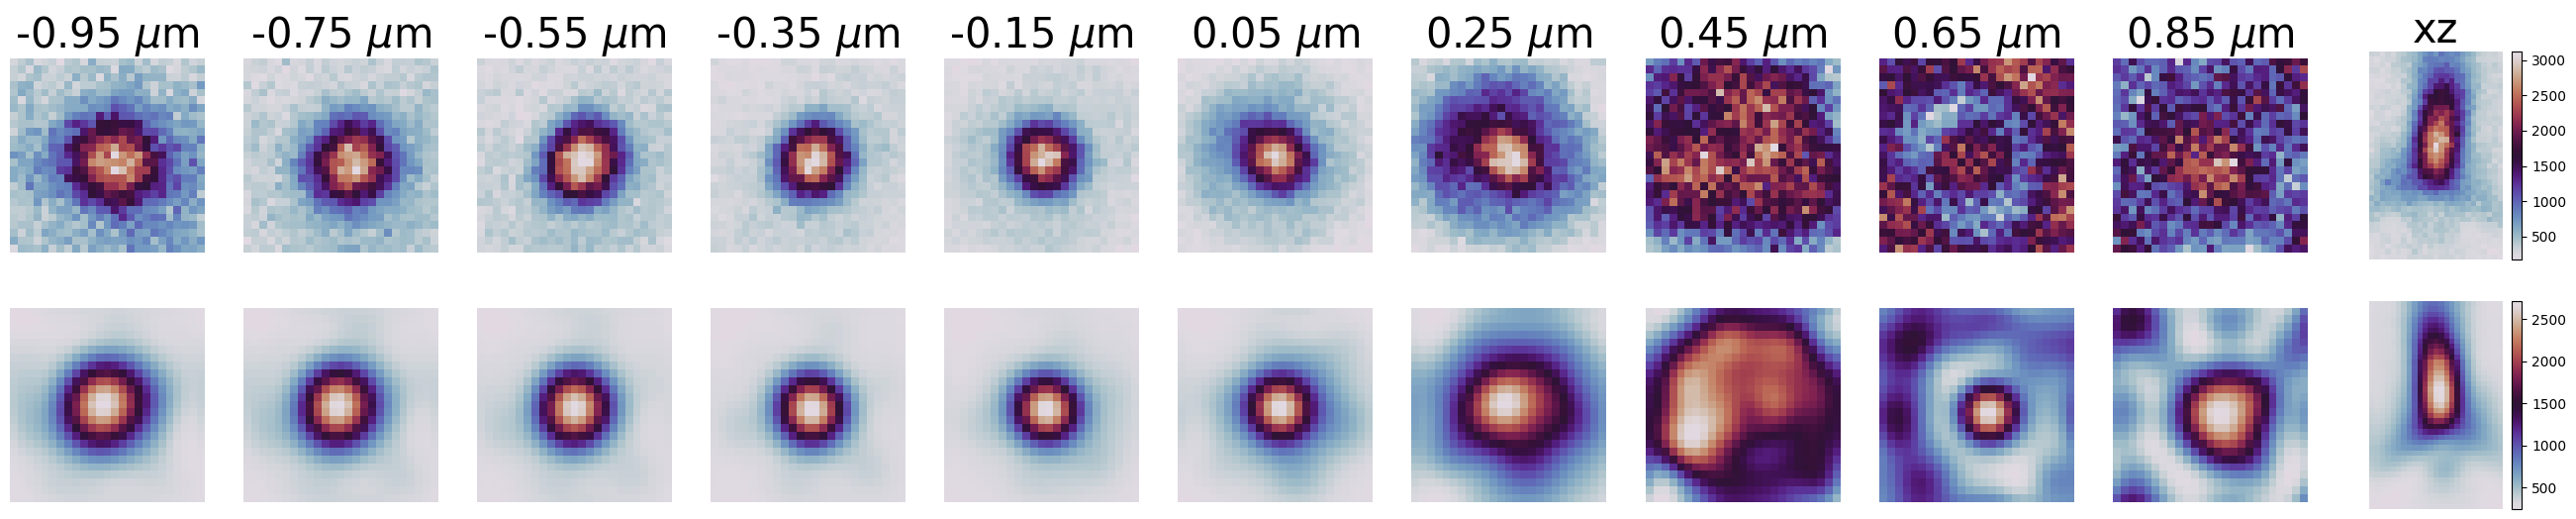

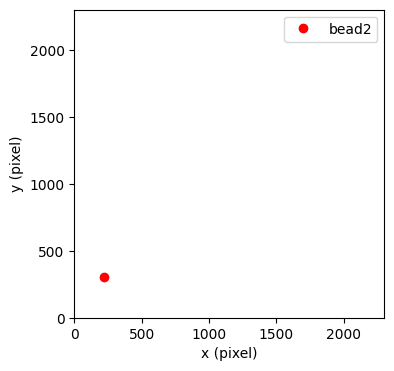

In [250]:
showpsfvsdata(f,p,index=2)

<Figure size 1000x1000 with 0 Axes>

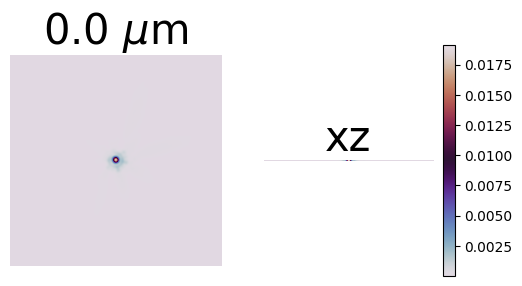

In [251]:
plt.figure(figsize=(10,10))
f,psfobj = L.genpsf(f,Nz=1,xsz=my_PSF.shape[1],stagepos=3.0)
showpsf(f,p)

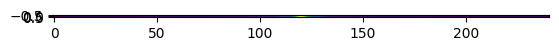

In [252]:
plt.imshow(np.array(f["res"]["I_model"]).sum(axis=2))

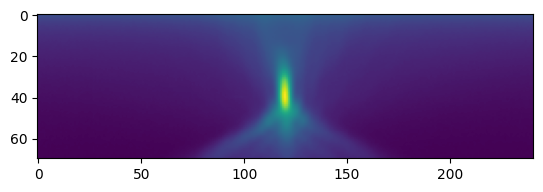

In [253]:
plt.imshow(np.array(my_PSF.sum(axis=2)[80:150]))

In [254]:
my_PSF = tifffile.imread("../PSF_comparison/average_100x_PSF_postmag_green.tif")

In [255]:
plt.imshow(f["res"]["I_model"].sum(axis=0))

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'sum'

In [ ]:
plt.figure(figsize=(10,10))
f,psfobj = L.genpsf(f,Nz=1,xsz=my_PSF.shape[1],stagepos=3.0)
showpsf(f,p)


In [ ]:
from skimage.transform import rotate
def get_midline_rotate_method(arr):
    mid_x = arr.shape[1]//2
    midline = np.array([rotate(arr, angle, resize = False, clip = True, preserve_range = True)[mid_x] for angle in range(366)]).mean(axis=0)
    return midline/midline.max()

In [ ]:
plt.plot(get_midline_rotate_method(my_PSF[my_PSF.shape[0]//2]))
plt.plot(get_midline_rotate_method(np.array(f["res"]["I_model"][0])))

plt.yscale("log")

In [ ]:
plt.imshow(my_PSF[my_PSF.shape[0]//2])

In [ ]:
plt.imshow(f["res"]["I_model"][0])

In [ ]:
showlocalization(f,p)

In [ ]:
try:
    showzernike(f,p)
except:
    try: 
        showpupil(f,p)
    except:
        print('no pupil')

In [ ]:
showlearnedparam(f,p)

In [ ]:
showcoord(f,p)